# Employee Performance & Retention Analysis

**Course:** Data Science

**What this notebook includes:**
- Load dataset from `/mnt/data/employee_data.csv`
- Exploratory Data Analysis (EDA)
- Data cleaning & preprocessing
- Feature engineering
- Modeling: Logistic Regression and Random Forest to predict employee attrition/retention
- Evaluation metrics and visualizations

All code cells are commented and markdown cells explain each step so you can submit this as your assignment.

## 1) Setup: imports and load dataset

In [3]:
# Imports (standard data science stack)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

# Load dataset
csv_path = 'employee_data.csv'
print('Loading dataset from:', csv_path)
try:
    df = pd.read_csv(csv_path)
    print('Dataset loaded successfully — shape:', df.shape)
except Exception as e:
    print('Error loading dataset:', e)

# Display first rows
df.head().style


Loading dataset from: employee_data.csv
Dataset loaded successfully — shape: (100, 8)


,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,Sales,55000,3,80,No
1,2,Jane Smith,35,HR,60000,7,85,No
2,3,Michael Brown,40,Engineering,80000,10,95,Yes
3,4,Emily Davis,28,Marketing,65000,5,78,No
4,5,David Johnson,50,Sales,75000,20,88,Yes


## 2) Quick EDA — structure, dtypes, missing values

In [4]:
# Dataframe info and basic stats
print('\n--- Dataframe info ---')
df.info()

print('\n--- Summary statistics (numeric) ---')
print(df.describe(include='all').transpose())

# Missing values
print('\n--- Missing values per column ---')
print(df.isnull().sum())



--- Dataframe info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   EmployeeID        100 non-null    int64 
 1   Name              100 non-null    object
 2   Age               100 non-null    int64 
 3   Department        100 non-null    object
 4   Salary            100 non-null    int64 
 5   YearsAtCompany    100 non-null    int64 
 6   PerformanceScore  100 non-null    int64 
 7   Attrition         100 non-null    object
dtypes: int64(5), object(3)
memory usage: 6.4+ KB

--- Summary statistics (numeric) ---
                  count unique           top freq     mean           std  \
EmployeeID        100.0    NaN           NaN  NaN     50.5     29.011492   
Name                100     98  James Walker    2      NaN           NaN   
Age               100.0    NaN           NaN  NaN    36.57      8.318478   
Department          1

## 3) Visualizations (matplotlib only)
We'll plot distributions for numeric columns and a correlation heatmap.

Numeric columns: ['EmployeeID', 'Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']


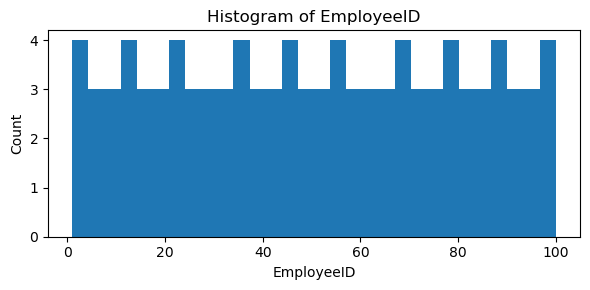

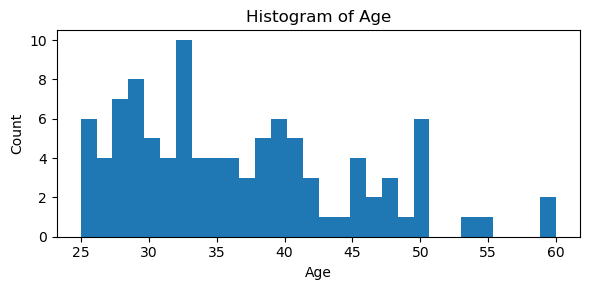

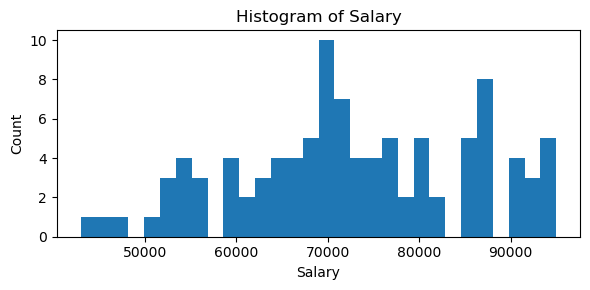

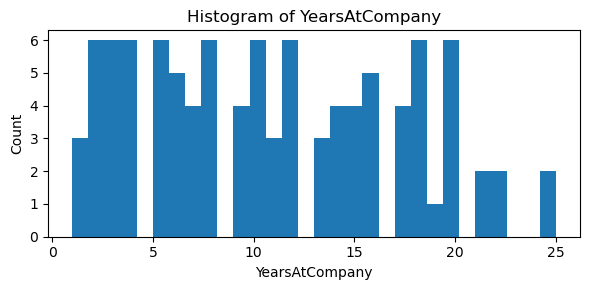

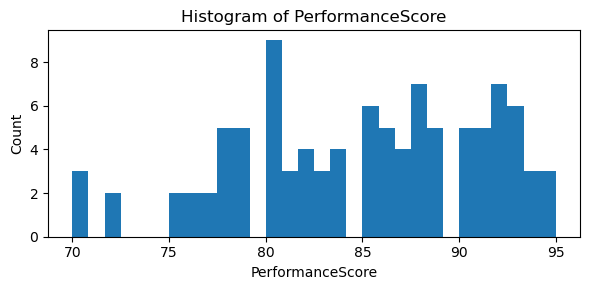

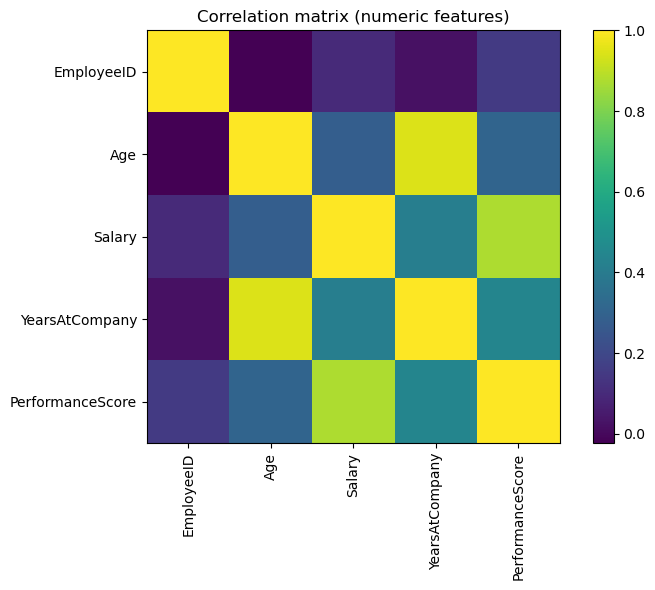

In [5]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns:', numeric_cols)

# Histogram for each numeric column (one figure per column)
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Correlation matrix heatmap (numeric only)
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title('Correlation matrix (numeric features)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')


## 4) Data cleaning & preprocessing
Plan:
1. Drop or impute missing values
2. Encode categorical variables
3. Scale numeric features
4. Create train/test split

In [6]:
# Copy dataframe to avoid accidental modification
working_df = df.copy()

# Example: show columns and unique value counts for object columns
obj_cols = working_df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical/object columns and sample unique counts:')
for c in obj_cols:
    print(c, '->', working_df[c].nunique())

# If there's a target column like 'Attrition' or 'Left', try to detect it
possible_targets = [c for c in working_df.columns if c.lower() in ['attrition','left','left_company','is_left','resigned','turnover']]
print('\nDetected possible target columns:', possible_targets)

# If target not detected, you'll need to set it manually. For now, we'll try 'Attrition' if present.
if 'Attrition' in working_df.columns:
    target_col = 'Attrition'
else:
    # fallback: if there is a column with only two unique values, pick first such column as target
    bin_cols = [c for c in working_df.columns if working_df[c].nunique() == 2]
    target_col = bin_cols[0] if bin_cols else None

print('Using target column:', target_col)


Categorical/object columns and sample unique counts:
Name -> 98
Department -> 4
Attrition -> 2

Detected possible target columns: ['Attrition']
Using target column: Attrition


## 5) Build preprocessing + modeling pipeline
This block constructs a scikit-learn pipeline that imputes, encodes, scales, and trains models.

In [10]:
# Ensure we have a target column
if target_col is None:
    raise ValueError('No target column detected automatically. Edit the notebook to set `target_col` manually.')

# Prepare X and y
X = working_df.drop(columns=[target_col])
y = working_df[target_col]

# For classification, ensure y is numeric (0/1)
if y.dtype == 'object' or y.dtype.name == 'category':
    # map common strings to 0/1
    y = y.astype(str).str.lower().map({'yes':1,'y':1,'true':1,'t':1,'1':1,'no':0,'n':0,'false':0,'f':0,'0':0}).fillna(y)
    try:
        y = y.astype(int)
    except Exception:
        # last resort: factorize
        y = pd.factorize(y)[0]

# Split columns for preprocessing
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', cat_features)

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, cat_features)
])

# Two models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Fit pipelines and evaluate
results = {}
for name, model in models.items():
    print('\nTraining', name)
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # some classifiers have predict_proba
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None

    results[name] = {
        'pipeline': pipe,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"{name} — accuracy: {results[name]['accuracy']:.4f}, f1: {results[name]['f1']:.4f}")

# Show a summary table
summary = pd.DataFrame([{
    'model': k,
    'accuracy': v['accuracy'],
    'precision': v['precision'],
    'recall': v['recall'],
    'f1': v['f1'],
    'roc_auc': v['roc_auc']
} for k,v in results.items()])

# Just display the summary table directly
print("Model results summary:")
display(summary)



Numeric features: ['EmployeeID', 'Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']
Categorical features: ['Name', 'Department']
Train shape: (80, 7) Test shape: (20, 7)

Training LogisticRegression
LogisticRegression — accuracy: 0.6000, f1: 0.4286

Training RandomForest
RandomForest — accuracy: 0.7500, f1: 0.5455
Model results summary:


,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.60,0.5,0.375,0.428571,0.625000
1,RandomForest,0.75,1.0,0.375,0.545455,0.791667


## 6) Confusion matrices and interpretation

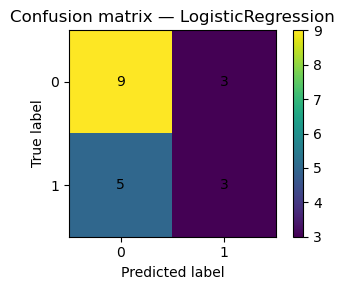

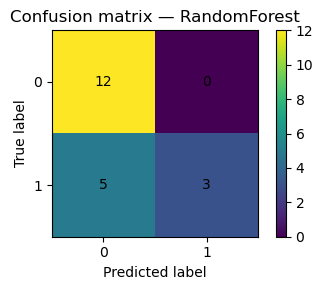

In [11]:
for name, res in results.items():
    cm = res['confusion_matrix']
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion matrix — {name}')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks([0,1])
    plt.yticks([0,1])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()


## 7) Feature importance (Random Forest)
If the Random Forest model exists, we extract feature importances.

In [24]:
if 'RandomForest' in results:
    rf_pipe = results['RandomForest']['pipeline']
    # get feature names after preprocessing
    # numeric features remain in order; one-hot creates many columns for categorical
    num_feats = numeric_features
    # get categorical feature names from onehot encoder
    cat_cols_names = []
    if cat_features:
        ohe = rf_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_cols = ohe.get_feature_names_out(cat_features)
        cat_cols_names = list(cat_cols)
    feature_names = num_feats + cat_cols_names
    importances = rf_pipe.named_steps['clf'].feature_importances_
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
    print("Top 20 feature importances (Random Forest):")
    display(imp_df)

else:
    print('RandomForest model not found in results.')


Top 20 feature importances (Random Forest):


,feature,importance
1,Age,0.146523
3,YearsAtCompany,0.113240
0,EmployeeID,0.110761
2,Salary,0.109813
4,PerformanceScore,0.090291
35,Name_James Walker,0.031250
63,Name_Michael Lewis,0.020063
86,Department_Sales,0.019095
85,Department_Marketing,0.017050
27,Name_George Harris,0.015352


## 8) Conclusions & next steps
- Review model metrics and confusion matrices to determine whether precision or recall is more important.
- Consider additional feature engineering (tenure buckets, interaction terms).
- Try more advanced models and cross-validation, or tune hyperparameters with GridSearchCV.

You can now download the notebook and run it locally or in Google Colab. If any column names differ from expected (for example the target isn't 'Attrition'), edit the `target_col` variable in the notebook and re-run the preprocessing/model sections.